In [1]:
##imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import plotly.express as px

from pydataset import data
from scipy import stats
import statistics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.feature_selection import RFE

#import warnings
#warnings.filterwarnings("ignore")


In [2]:
def split_data(df,target):
    ''' 
    takes in dataframe
    uses train test split on data frame using test size of 2, returns train_validate, test
    uses train test split on train_validate using test size of .3, returns train and validate
    returns train, validate test
    '''
    train_validate, test = train_test_split(df, test_size= .2, random_state=514,stratify = df[target])
    train, validate = train_test_split(train_validate, test_size= .3, random_state=514,stratify = train_validate[target])
    print(train.shape, validate.shape, test.shape)
    return train, validate, test

def scale_split_data (train, validate, test):
    ''' 
    takes in your three datasets
    applies minmax scaler to them using dtypes of number
    fits to those columns
    applies to copies of datasets
    returns datasets scaled
    '''
    #create scaler object
    scaler = MinMaxScaler()

    # create copies to hold scaled data
    train_scaled = train.copy(deep=True)
    validate_scaled = validate.copy(deep=True)
    test_scaled =  test.copy(deep=True)

    #create list of numeric columns for scaling
    num_cols = train.select_dtypes(include='number')

    #fit to data
    scaler.fit(num_cols)

    # apply
    train_scaled[num_cols.columns] = scaler.transform(train[num_cols.columns])
    validate_scaled[num_cols.columns] =  scaler.transform(validate[num_cols.columns])
    test_scaled[num_cols.columns] =  scaler.transform(test[num_cols.columns])

    return train_scaled, validate_scaled, test_scaled


def get_kmeans_cluster_features(train,train_scaled,validate,validate_scaled,test,test_scaled,dict_to_cluster):
    ''' 
    takes in your three datasets to apply the new featuers to as well as applying to the base datasets
    a dictionary (iterable lists with the last being the order of clustering (function to auto later))
    '''

    for i in range(len(list(dict_to_cluster))-1):
        #set features
        X1 = train_scaled[dict_to_cluster[list(dict_to_cluster)[i]]]
        X2 = validate_scaled[dict_to_cluster[list(dict_to_cluster)[i]]]
        X3 = test_scaled[dict_to_cluster[list(dict_to_cluster)[i]]]

        kmeans_scaled = KMeans(n_clusters=dict_to_cluster[list(dict_to_cluster)[len(list(dict_to_cluster))-1]][i],random_state=123)
        kmeans_scaled.fit(X1)

        X1["cluster"] = kmeans_scaled.predict(X1)
        X2["cluster"] = kmeans_scaled.predict(X2)
        X3["cluster"] = kmeans_scaled.predict(X3)

        train_scaled[f"cluster {list(dict_to_cluster)[i]}"] = X1["cluster"]
        train[f"cluster {list(dict_to_cluster)[i]}"] = X1["cluster"]

        validate_scaled[f"cluster {list(dict_to_cluster)[i]}"] = X2["cluster"]
        validate[f"cluster {list(dict_to_cluster)[i]}"] = X2["cluster"]

        test_scaled[f"cluster {list(dict_to_cluster)[i]}"] = X3["cluster"]
        test[f"cluster {list(dict_to_cluster)[i]}"] = X3["cluster"]

    return train,train_scaled,validate,validate_scaled,test,test_scaled

def rfe(predictors_x,target_y,n_features):
    ''' 
    takes in the predictors (X) (predictors_x), the target (y) (target_y), and the number of features to select (k) 
    returns the names of the top k selected features based on the Recursive Feature Elimination class. and a ranked df
    '''

    model = LinearRegression()
    rfe = RFE(model,n_features_to_select=n_features)
    rfe.fit(predictors_x,target_y)

    #print(pd.DataFrame({"rfe_ranking":rfe.ranking_},index=predictors_x.columns).sort_values("rfe_ranking")[:n_features])
    X_train_transformed = pd.DataFrame(rfe.transform(predictors_x),columns=predictors_x.columns[rfe.get_support()],index=predictors_x.index)
    X_train_transformed.head(3)

    var_ranks = rfe.ranking_
    var_names = predictors_x.columns.tolist()

    rfe_ranked = pd.DataFrame({'Var': var_names, 'Rank': var_ranks}).sort_values("Rank")
    
    return rfe_ranked


def summarize(df):
    '''  
    takes in dataframe
    prints out df info and df describe as well as the amount of nulls in df by column and row
    then it finds the dtypes of "number" and makes the inverse categorical
    prints out the value counts of cats, as well as binning and doing the same for numerical
    '''
    print('-----')
    print('DataFrame info:\n')
    print (df.info())
    print('---')
    print('DataFrame describe:\n')
    print (df.describe())
    print('---')
    #print('DataFrame null value asssessment:\n')
    #print('Nulls By Column:', nulls_by_col(df))
    #print('----')
    #print('Nulls By Row:', nulls_by_row(df))
    numerical_cols = df.select_dtypes(include='number').columns.to_list()
    categorical_cols = df.select_dtypes(exclude='number').columns.to_list()
    print('value_counts: \n')
    for col in df.columns:
        print(f'Column Names: {col}')
        if col in categorical_cols:
            print(df[col].value_counts())
        else:
            print(df[col].value_counts(bins=10, sort=False, dropna=False))
            print('---')
    print('Report Finished')
    return

def FE_IF_model(train, train_scaled, validate, validate_scaled, test, test_scaled,indicate):
    ''' 
    input datasets and list of features to run model with
    creates,fits and predicts, plots peformance against target
    returns same datasets with predictor feature
    '''
    model = IsolationForest(contamination=float(.002),random_state=123,bootstrap=True)
    model.fit(train_scaled[indicate])
    train["if1_scores"] = model.decision_function(train_scaled[indicate])
    train["if1_anom"] = model.predict((train_scaled[indicate]))
    train_scaled["if1_anom"] = model.predict((train_scaled[indicate]))
    validate["if1_anom"] = model.predict((validate_scaled[indicate]))
    validate_scaled["if1_anom"] = model.predict((validate_scaled[indicate]))
    test["if1_anom"] = model.predict((test_scaled[indicate]))
    test_scaled["if1_anom"] = model.predict((test_scaled[indicate]))

    #plt.title("anomaly class compared to target") # Title with column name.
    #train[train["Class"]==0]["if1_anom"].hist(bins=10,alpha=.5) # Display histogram for column.
    #train[train["Class"]==1]["if1_anom"].hist(bins=10,alpha=.5) # Display histogram for column.
    #plt.yscale("log")
    #plt.grid(False) # Hide gridlines
    #plt.show()

    train[["if1_anom","Class"]].groupby(["if1_anom"]).agg(["count","mean"])

    return train, train_scaled, validate, validate_scaled, test, test_scaled

def correlation_guidance(train,target):
    ''' 
    input train dataset and target string
    creates a correlation plot of the variables in the columns list (self defined) by class
    no return
    '''
    plt.figure(figsize=(30, 30))
    for i,col1 in enumerate(train.iloc[:,1:30].columns.tolist()):
        plt.subplot(5,6,i+1)
        x=train[train[target]==0][col1].sample(len(train[train[target]==1]))
        y=train[train[target]==1][col1]
        plt.plot(x, y, "o",color="grey")
        m,b = np.polyfit(x,y,1)
        plt.plot(x,m*x+b,label=f"regression line - f(x)={round(m,3)}x+{round(b,1)}")
        plt.xlabel("No-Fraud")
        plt.ylabel("Yes-Fraud")
        plt.legend()
        plt.title(f"Fraud by {col1} value")
    plt.show()

# Acquire
> - feature names are unknown to protect confidentiality, will create features and see how they interact
> - No cleaning required, good clean dataset
> - Created a few features to try and gain an edge on predicting target class
> - Renamed/mapped Class to Fraud (will need to drop) for reading comp ability

In [3]:
#get the data and set target
df = pd.read_csv("~/Downloads/creditcard.csv")
target="Class"

#create a new feature that is the product of valuable features (will explore later)
rfe_ranked=rfe(df.drop(columns=target),df[target],10)
indicate = rfe_ranked[rfe_ranked["Rank"]==1]["Var"].tolist()
df["indicate"] = 1
for i in indicate:
    df["indicate"] = df['indicate']*df[i]

#get prepared to cluster
dict_to_cluster = { "zero":['V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17'],
                    "030409":['V3', 'V4', 'V9'],
                    "101112":['V10', 'V11', 'V12'],
                    "141617":['V14', 'V16', 'V17'],
                    "cluster_order":[4,4,4,4]}
cluster_list = ["cluster zero","cluster one","cluster two","cluster three"]

#split and scale data, cluster for FE
train,validate,test = split_data(df,target)
train_scaled, validate_scaled, test_scaled = scale_split_data(train,validate,test)
train, train_scaled, validate, validate_scaled, test, test_scaled = get_kmeans_cluster_features(train,train_scaled,validate,validate_scaled,test,test_scaled,dict_to_cluster )

#more feature engineering
FE_IF_model(train, train_scaled, validate, validate_scaled, test, test_scaled,indicate)

## changing class to better describe what we're looking for in exploration, will drop
train["Fraud"] = train.Class.map({0:"No-Fraud",1:"Yes-Fraud"})
summarize(df)

(159491, 32) (68354, 32) (56962, 32)


/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_86406/4231578661.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X1["cluster"] = kmeans_scaled.predict(X1)
/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_86406/4231578661.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2["cluster"] = kmeans_scaled.predict(X2)
/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_86406/4231578661.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

-----
DataFrame info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 32 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Time      284807 non-null  float64
 1   V1        284807 non-null  float64
 2   V2        284807 non-null  float64
 3   V3        284807 non-null  float64
 4   V4        284807 non-null  float64
 5   V5        284807 non-null  float64
 6   V6        284807 non-null  float64
 7   V7        284807 non-null  float64
 8   V8        284807 non-null  float64
 9   V9        284807 non-null  float64
 10  V10       284807 non-null  float64
 11  V11       284807 non-null  float64
 12  V12       284807 non-null  float64
 13  V13       284807 non-null  float64
 14  V14       284807 non-null  float64
 15  V15       284807 non-null  float64
 16  V16       284807 non-null  float64
 17  V17       284807 non-null  float64
 18  V18       284807 non-null  float64
 19  V19       284807 non-

# Exploration
- Initial phase - Guidance

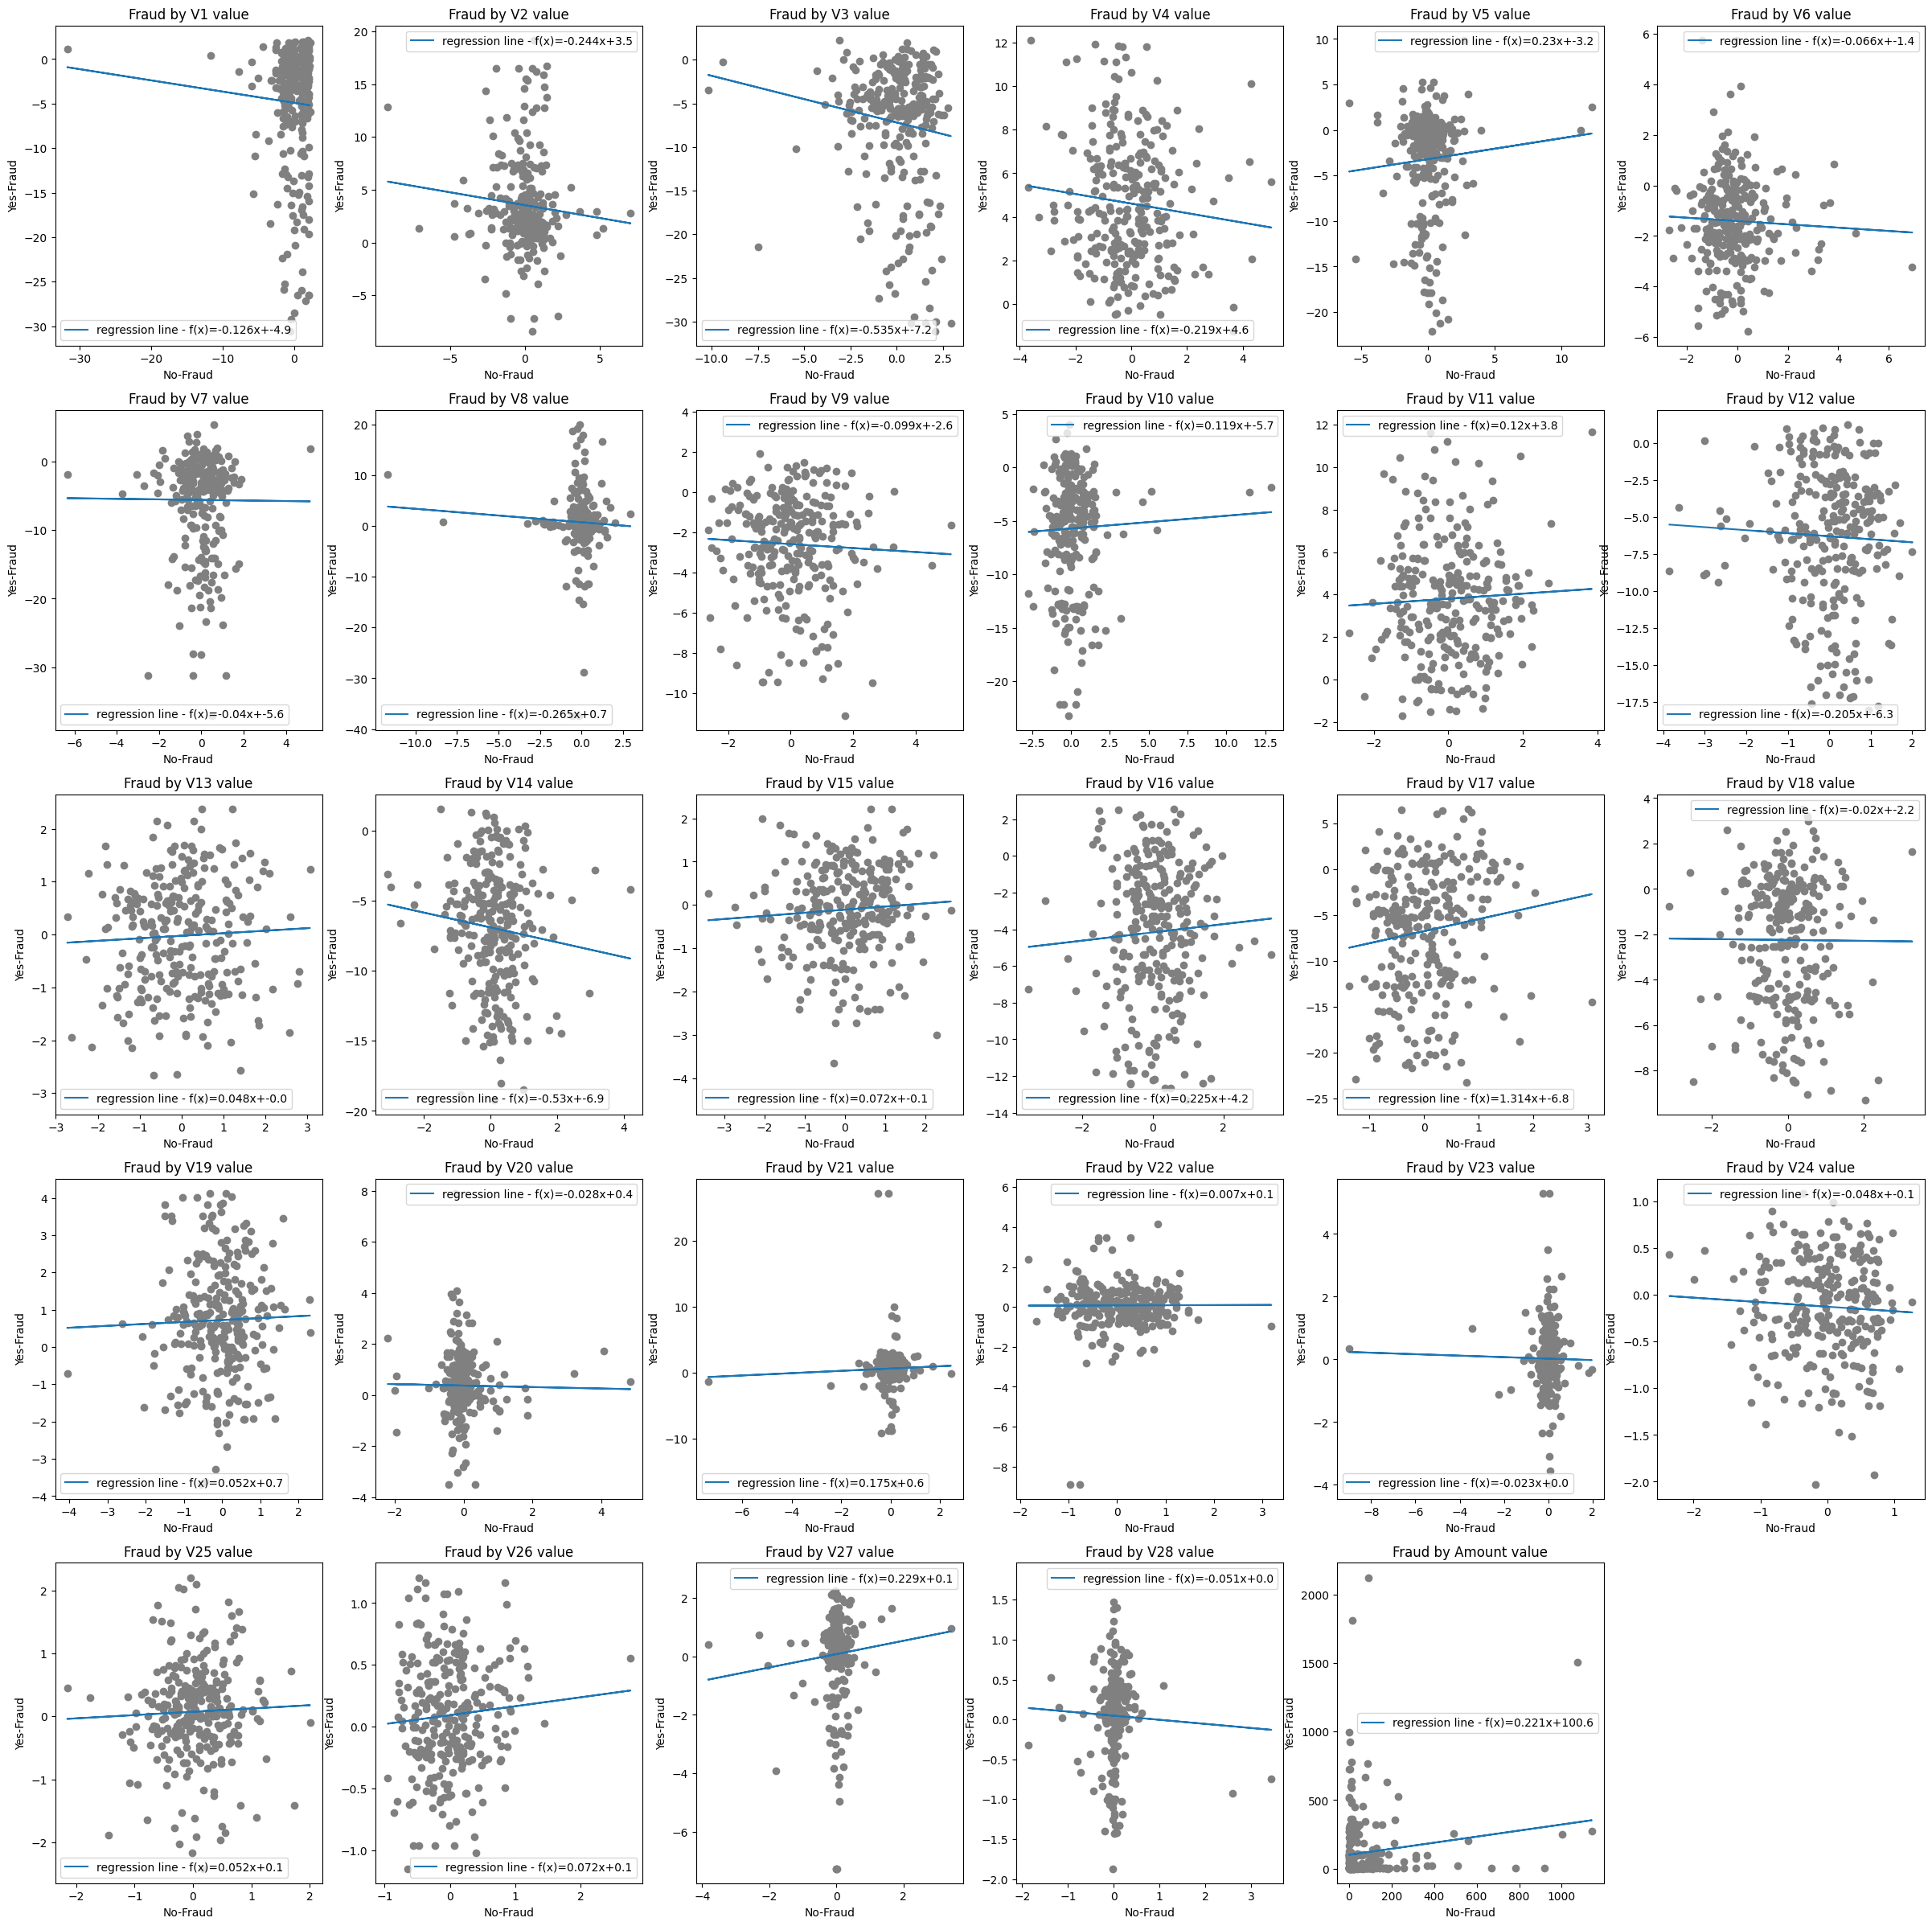

In [4]:
correlation_guidance(train,target)

### Takeaway 
- So we're looking for narrow spreads, this indicated that the majority of information that falls into one class (fraud or no fraud) is unlikey to fall into the other (see V28, if a window was created at approx. +/- 0.5 there would be a decent capture of Fraud and not so much of No Fraud (precsion vs recall))

In [5]:
pd.concat({'Observed': df1.T[col], 'Expected': dfexpected.T[col]}, axis=1)

NameError: name 'df1' is not defined

In [ ]:
dfexpected

cluster three,0,1,2,3
Fraud,,,,
No-Fraud,47701.309541,78519.885385,32823.10099,170.704084
Yes-Fraud,82.690459,136.114615,56.89901,0.295916


Observed
[[57908 36536 54223 10548]
 [   18     2    72   184]]
---
Expected
[[5.78257588e+04 3.64747708e+04 5.42010422e+04 1.07134282e+04]
 [1.00241242e+02 6.32291979e+01 9.39577782e+01 1.85717815e+01]]
---
chi^2 = 1608.2330, p = 0.00000, degf = 3
due to p = 0.00000 < α = 0.05 we reject our null hypothesis
(  F̶r̶a̶u̶d̶ ̶i̶s̶ ̶i̶n̶d̶e̶p̶e̶n̶d̶a̶n̶t̶ ̶o̶f̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶z̶e̶r̶o̶ )


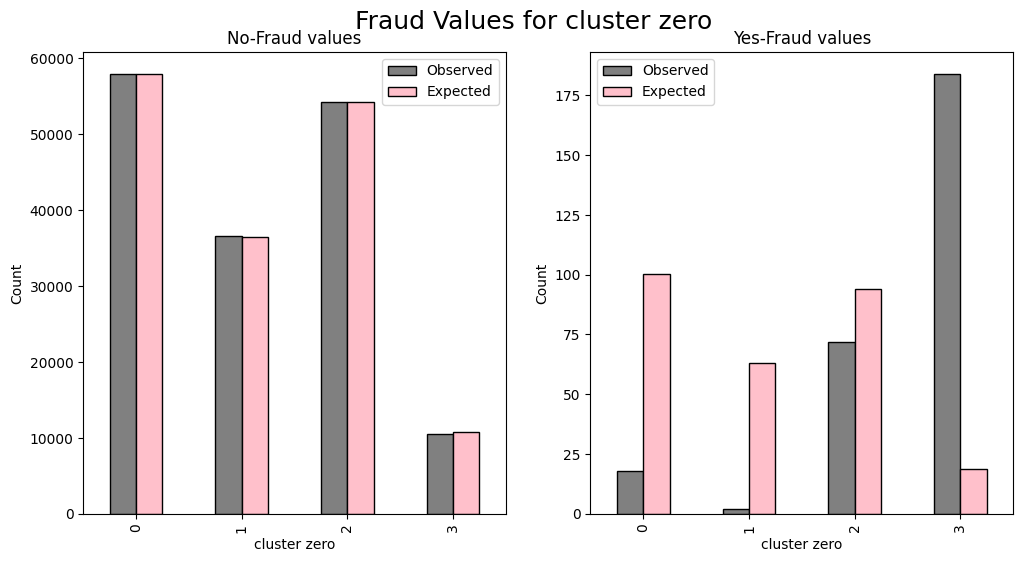

Observed
[[51018 21546 10563 76088]
 [    6     1   224    45]]
---
Expected
[[5.09357027e+04 2.15097128e+04 1.07683330e+04 7.60012514e+04]
 [8.82972958e+01 3.72871949e+01 1.86669593e+01 1.31748550e+02]]
---
chi^2 = 2431.9711, p = 0.00000, degf = 3
due to p = 0.00000 < α = 0.05 we reject our null hypothesis
(  F̶r̶a̶u̶d̶ ̶i̶s̶ ̶i̶n̶d̶e̶p̶e̶n̶d̶a̶n̶t̶ ̶o̶f̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶o̶n̶e̶ )


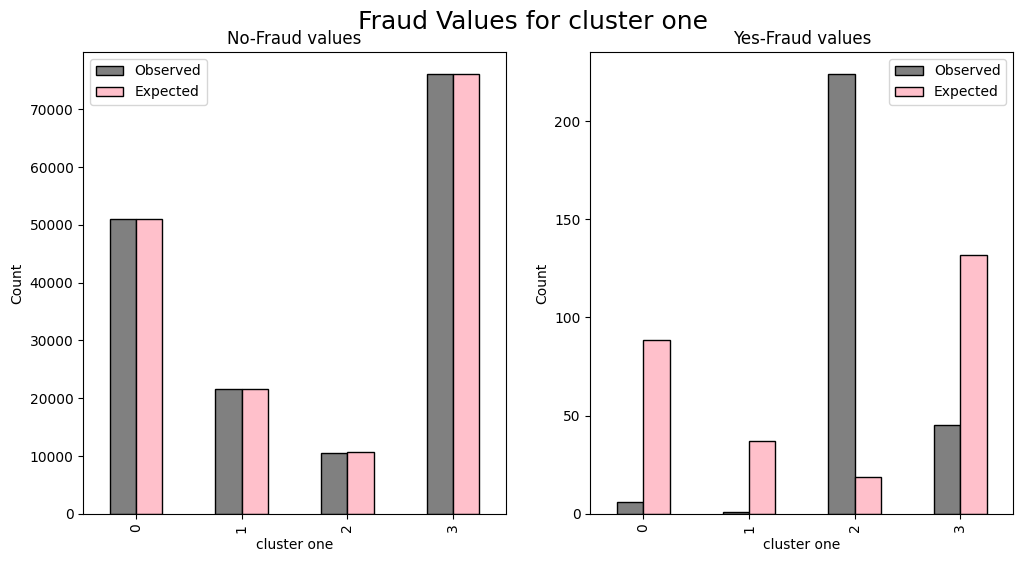

Observed
[[45517 45079 11383 57236]
 [   12    17   232    15]]
---
Expected
[[4.54502118e+04 4.50179611e+04 1.15949002e+04 5.71519268e+04]
 [7.87881699e+01 7.80388611e+01 2.00998175e+01 9.90731515e+01]]
---
chi^2 = 2413.8144, p = 0.00000, degf = 3
due to p = 0.00000 < α = 0.05 we reject our null hypothesis
(  F̶r̶a̶u̶d̶ ̶i̶s̶ ̶i̶n̶d̶e̶p̶e̶n̶d̶a̶n̶t̶ ̶o̶f̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶t̶w̶o̶ )


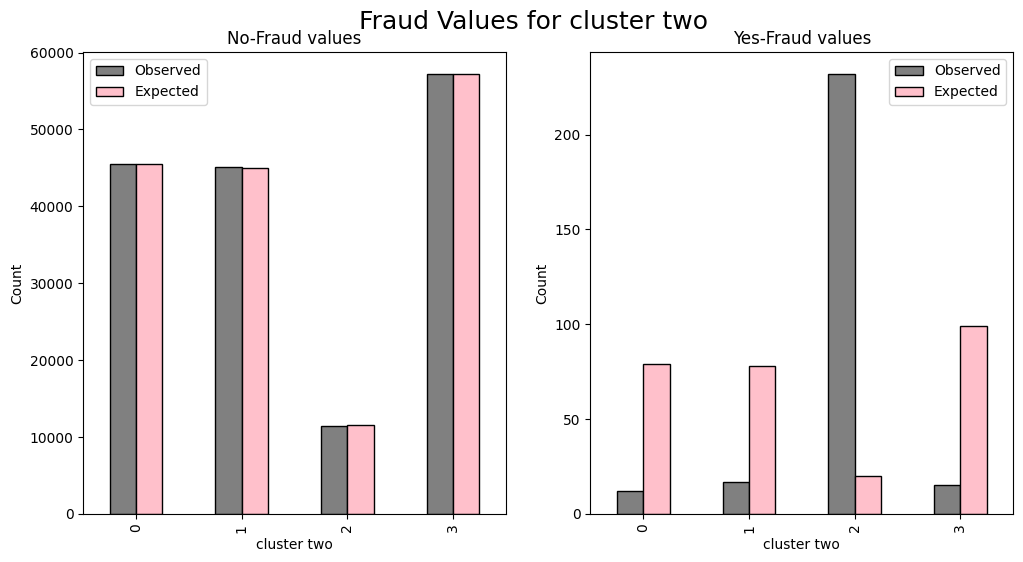

Observed
[[47718 78647 32821    29]
 [   66     9    59   142]]
---
Expected
[[4.77013095e+04 7.85198854e+04 3.28231010e+04 1.70704084e+02]
 [8.26904590e+01 1.36114615e+02 5.68990100e+01 2.95916384e-01]]
---
chi^2 = 68097.1650, p = 0.00000, degf = 3
due to p = 0.00000 < α = 0.05 we reject our null hypothesis
(  F̶r̶a̶u̶d̶ ̶i̶s̶ ̶i̶n̶d̶e̶p̶e̶n̶d̶a̶n̶t̶ ̶o̶f̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶t̶h̶r̶e̶e̶ )


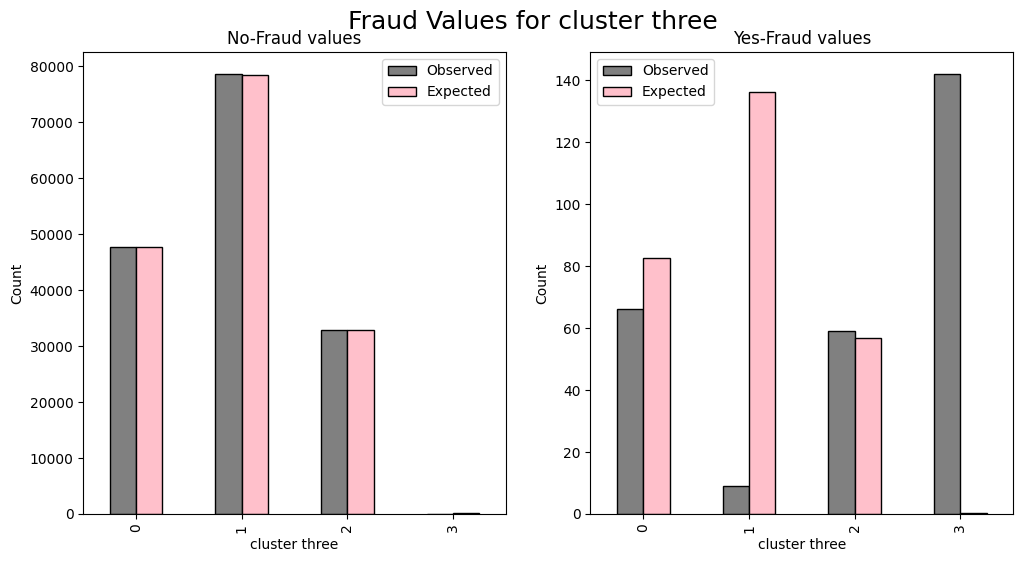

In [ ]:
# creates a column of the payments for easy analysis, runs a crosstab to put into a chi2 independancy test.
# produces observed and expected values
# returns the chi2 and pval for the whole set

for i in cluster_list:

    df1 = pd.crosstab(train["Fraud"],train[i])

    alpha = .05
    chi2, p, degf, expected = stats.chi2_contingency(df1)
    H0 = (f"{df1.index.name} is independant of {df1.columns.name}")
    H1 = (f"{df1.index.name} is not independant of {df1.columns.name}")
    print('Observed')
    print(df1.values)
    print('---\nExpected')
    dfexpected = df1.copy()
    for i in range(len(dfexpected)):
        dfexpected.iloc[i] = expected[i]
    print(dfexpected.values)
    print(f'---\nchi^2 = {chi2:.4f}, p = {p:.5f}, degf = {degf}')
    if p>alpha:
        print(f"due to p={p:.5f} > α={alpha} we fail to reject our null hypothesis\n({H0})")
    else:
        print(f"due to p = {p:.5f} < α = {alpha} we reject our null hypothesis\n( ", '\u0336'.join(H0) + '\u0336' , ")")

    #plot the results
    plt.figure(figsize=(12,6))
    plt.suptitle(f"{df1.index.name} Values for {df1.columns.name}", fontsize=18, y=0.95)

    for x,col in enumerate(df1.T.columns):
        ax = plt.subplot(1,2,x+1)
        pd.concat({'Observed': df1.T[col], 'Expected': dfexpected.T[col]}, axis=1).\
            plot.bar(color={"Observed": "grey", "Expected": "pink"}, edgecolor="black",ax=ax)
        ax.set_ylabel("Count")
        ax.set_title(f'{col} values') # Title with column name.
    plt.show()

Cluster0-3, Cluster1-2, Cluster2-2, and Cluster3-3 will all be good drivers for determining fraud

In [ ]:
train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V27,V28,Amount,Class,indicate,cluster zero,cluster one,cluster two,cluster three,Fraud
164298,116618.0,-1.917214,2.360857,-0.541292,-2.270248,2.170464,-0.961343,3.427261,-2.286056,3.334185,...,-0.454608,-1.739137,3.78,0,1.743665e+02,2,1,1,0,No-Fraud
76785,56741.0,-0.326266,1.062432,1.218863,0.877946,-0.063750,-0.731441,0.824376,-0.164448,-0.444057,...,0.043309,0.152724,26.90,0,4.300773e-04,0,3,0,1,No-Fraud
19931,30658.0,1.152464,-0.194226,1.026204,0.764573,-0.780215,0.014423,-0.509632,0.027441,0.781880,...,0.017731,0.030535,42.45,0,1.131500e-02,0,3,0,2,No-Fraud
74935,55818.0,0.925078,-0.060813,0.140973,1.239721,-0.307980,-0.874732,0.534606,-0.356948,-0.251597,...,-0.008312,0.052279,170.13,0,1.859196e-07,0,3,3,1,No-Fraud
221353,142537.0,-2.131722,-1.746730,1.502770,1.102237,0.660407,0.164645,0.691076,0.136400,-1.066810,...,-0.161192,-0.012641,381.04,0,5.247456e-02,3,3,3,1,No-Fraud
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122359,76529.0,1.155468,-0.147214,0.446042,0.656559,-0.278421,0.373135,-0.347142,0.231199,0.450403,...,-0.007504,-0.006428,10.00,0,6.620377e-06,2,3,1,0,No-Fraud
111150,72115.0,1.197556,0.439484,0.238488,1.044275,-0.102496,-0.850878,0.340471,-0.201666,-0.532753,...,0.005196,0.010519,5.10,0,2.459009e-04,2,3,1,1,No-Fraud
153156,98048.0,-1.043097,1.102120,-0.403234,-1.841771,3.278751,3.647057,0.072836,0.107068,0.825083,...,0.005703,0.053466,5.43,0,7.606971e-01,1,1,2,1,No-Fraud
179483,124097.0,1.972209,-0.962857,-1.020015,-0.483226,-0.423093,0.194608,-0.601087,0.086321,-0.213862,...,0.018123,-0.028143,76.79,0,-1.776780e-03,2,0,3,0,No-Fraud


In [ ]:
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,Amount,Class,indicate,cluster zero,cluster one,cluster two,cluster three,if1_scores,if1_anom,Fraud
164298,116618.0,-1.917214,2.360857,-0.541292,-2.270248,2.170464,-0.961343,3.427261,-2.286056,3.334185,...,3.78,0,-4.262034e+01,2,1,1,0,0.108543,1,No-Fraud
76785,56741.0,-0.326266,1.062432,1.218863,0.877946,-0.063750,-0.731441,0.824376,-0.164448,-0.444057,...,26.90,0,-1.845502e-04,0,3,0,1,0.307733,1,No-Fraud
19931,30658.0,1.152464,-0.194226,1.026204,0.764573,-0.780215,0.014423,-0.509632,0.027441,0.781880,...,42.45,0,1.566379e-03,0,3,0,2,0.293989,1,No-Fraud
74935,55818.0,0.925078,-0.060813,0.140973,1.239721,-0.307980,-0.874732,0.534606,-0.356948,-0.251597,...,170.13,0,1.153743e-07,0,3,3,1,0.304096,1,No-Fraud
221353,142537.0,-2.131722,-1.746730,1.502770,1.102237,0.660407,0.164645,0.691076,0.136400,-1.066810,...,381.04,0,-1.696511e-02,3,3,3,1,0.230635,1,No-Fraud


In [ ]:
[col for col in train.columns if 'cluster' in col]

['cluster zero', 'cluster one', 'cluster two', 'cluster three']

In [ ]:
for each in [col for col in train.columns if 'cluster' in col]:
    # sets variables
    target = "Class"
    alpha = .025
    population_name = each
    for sub_cat in train[each].unique():
        sample_name = sub_cat

        print(target,"=target |",population_name,"=pop name |",sample_name,"=samp name")
        
        #sets null hypothesis
        H0 = f"{sample_name} as a sample has equal mean values to {population_name} as a population regarding {target}"
        Ha = f"{sample_name} as a sample does not have equal mean values to {population_name} as a population regarding {target}"

        #runs test and prints results
        t, p = stats.ttest_1samp( train[train[population_name] == sample_name][target], train[target].mean())
        if p > alpha:
            print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
        else:
            print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))


Class =target | cluster zero =pop name | 2 =samp name

 We reject the null Hypothesis ( 2̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶m̶e̶a̶n̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶z̶e̶r̶o̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶C̶l̶a̶s̶s̶ ) t=-2.58944, p=0.00962
Class =target | cluster zero =pop name | 0 =samp name

 We reject the null Hypothesis ( 0̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶m̶e̶a̶n̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶z̶e̶r̶o̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶C̶l̶a̶s̶s̶ ) t=-19.38729, p=0.00000
Class =target | cluster zero =pop name | 3 =samp name

 We reject the null Hypothesis ( 3̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶m̶e̶a̶n̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶l̶u̶s̶t̶e̶r̶ ̶z̶e̶r̶o̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶C̶l̶a̶s̶s̶ ) t=12.30087, p=0.00000
Class =target | cluster zero =pop name | 1 =samp name

 We reject the null Hypothesis ( 1̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶m̶e̶a̶n̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶

Confirms what i saw in my CHI^2 tests

In [ ]:
## does a levene test for comparing variance, creates a boolean flag that is passed into the ttest for
## comparing the Fraud monthly charge and the Not Fraud monthly charge
## then plots the graphs for a visual

cat = "indicate"

H0 = "Feature Engineered of Fraud is equal to Feature Engineered of Not Fraud"
Ha = "Feature Engineered of Fraud is less than or greater than Feature Engineered of Not Fraud"
alpha = .05

#compare variances to know how to run the test
stat,pval = stats.levene(train[train[target]==1][cat],train[train[target]==0][cat])
stat,pval
if pval > 0.05:
    equal_var_flag = True
    print(f"we can accept that there are equal variance in these two groups with {round(pval,2)} certainty Flag=T",'stat=%.5f, p=%.5f' % (stat,pval))
else:
    equal_var_flag = False
    print(f"we can reject that there are equal variance in these two groups with {round((1-pval),2)} certainty Flag=F",'stat=%.5f, p=%.5f' % (stat,pval))


t, p = stats.ttest_ind( train[train[target]==1][cat], train[train[target]==0][cat], equal_var = equal_var_flag )

if p > alpha: #directionality, or if t is negative
    print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
else:
     print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))


we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=32051.87002, p=0.00000

 We reject the null Hypothesis ( F̶e̶a̶t̶u̶r̶e̶ ̶E̶n̶g̶i̶n̶e̶e̶r̶e̶d̶ ̶o̶f̶ ̶F̶r̶a̶u̶d̶ ̶i̶s̶ ̶e̶q̶u̶a̶l̶ ̶t̶o̶ ̶F̶e̶a̶t̶u̶r̶e̶ ̶E̶n̶g̶i̶n̶e̶e̶r̶e̶d̶ ̶o̶f̶ ̶N̶o̶t̶ ̶F̶r̶a̶u̶d̶ ) t=7.48875, p=0.00000


The feature engineered "indicate" which is a product of the features with the highest outliers is a significant player in determining fraud